In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import doctest
import copy

In [ ]:
#https://stackoverflow.com/questions/40137950/possible-to-run-python-doctest-on-a-jupyter-cell-function
def test(func):
    '''
    Use test as a decorator to a function with doctests in Jupyter notebook. 
    Run the cell to see the results of the doctests.
    '''
    globs = copy.copy(globals())
    globs.update({func.__name__:func})
    doctest.run_docstring_examples(func, globs, verbose=True, name=func.__name__)
    return func

### Simulate straight line and circular movements with Bicycle model

Robot is at the origin (0, 0) and facing North, i.e, $\theta = \pi/2$. Assume the wheelbase of the vehicle $L$ = 0.9 m

In [ ]:
@test 
def bicycle_model(curr_pose, v, delta, L, dt=1.0):
    '''
    >>> bicycle_model((0.0,0.0,0.0), 1.0, 0.0)
    (1.0, 0.0, 0.0)
    >>> bicycle_model((0.0,0.0,0.0), 0.0, np.pi/4)
    (0.0, 0.0, 0.0) 
    >>> bicycle_model((0.0, 0.0, 0.0), 1.0, np.pi/4)
    (1.0, 0.0, 1.11) 
    '''
    # write code to calculate next_pose
    # refer to the kinematic equations of a bicycle model
    x, y, theta = curr_pose[0], curr_pose[1], curr_pose[2]
    x = x + v * np.cos(theta)*dt
    y = y + v*np.sin(theta)*dt
    theta = theta + (v/L) * np.tan(delta) * dt 
    
    # Keep theta bounded between [-pi, pi]
    theta = np.arctan2(np.sin(theta), np.cos(theta))
    # return calculated (x, y, theta)
    return x, y, theta


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.7/doctest.py", line 1487, in run
    sys.settrace(save_trace)



Finding tests in bicycle_model
Trying:
    bicycle_model((0.0,0.0,0.0), 1.0, 0.0)
Expecting:
    (1.0, 0.0, 0.0)
**********************************************************************
File "__main__", line 4, in bicycle_model
Failed example:
    bicycle_model((0.0,0.0,0.0), 1.0, 0.0)
Exception raised:
    Traceback (most recent call last):
      File "/usr/lib/python3.7/doctest.py", line 1337, in __run
        compileflags, 1), test.globs)
      File "<doctest bicycle_model[0]>", line 1, in <module>
        bicycle_model((0.0,0.0,0.0), 1.0, 0.0)
    TypeError: bicycle_model() missing 1 required positional argument: 'L'
Trying:
    bicycle_model((0.0,0.0,0.0), 0.0, np.pi/4)
Expecting:
    (0.0, 0.0, 0.0) 
**********************************************************************
File "__main__", line 6, in bicycle_model
Failed example:
    bicycle_model((0.0,0.0,0.0), 0.0, np.pi/4)
Exception raised:
    Traceback (most recent call last):
      File "/usr/lib/python3.7/doctest.py", line 1337

In [ ]:
#straight line
straight_trajectory = []
pose = (0, 0, np.pi/2)
steps = 1000
#fill in v and delta values
v = np.ones(steps)
delta = np.zeros(steps)
for i in range(steps):
   #instruction to take v, delta and compute new pose  
   straight_trajectory.append(pose)  
   # store new pose
   pose = bicycle_model(pose, v[i], delta[i], 0.9)
straight_trajectory.append(pose)
straight_trajectory = np.array(straight_trajectory)
    

In [ ]:
#circle
circular_trajectory = []
pose = (0, 0, np.pi/2)
steps = 1000

#fill in v and omega values
all_v = np.ones(steps)
all_d = np.ones(steps)
for v, d in zip(all_v, all_d):
   # store pose
   circular_trajectory.append(pose)
   #instruction to take v, w and compute new pose    
   pose = bicycle_model(pose, v, d, 0.9, 0.1)
circular_trajectory = np.array(circular_trajectory)
print(circular_trajectory)


[[ 0.00000000e+00  0.00000000e+00  1.57079633e+00]
 [ 6.12323400e-18  1.00000000e-01  1.74384163e+00]
 [-1.72182964e-02  1.98506499e-01  1.91688693e+00]
 ...
 [-1.12037158e+00  2.47288706e-01 -1.83222544e+00]
 [-1.14621772e+00  1.50686546e-01 -1.65918014e+00]
 [-1.15504459e+00  5.10768771e-02 -1.48613484e+00]]


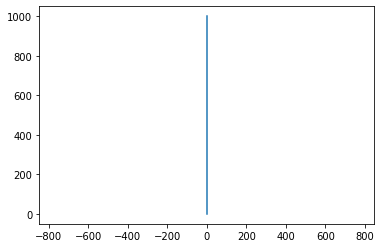

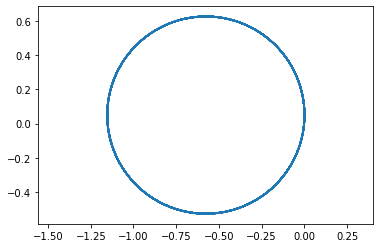

In [ ]:
### Plot straight and circular trajectories
plt.figure()
plt.axes().set_aspect("equal","datalim")
plt.plot(straight_trajectory[:,0], straight_trajectory[:,1])

### Plot straight and circular trajectories
plt.figure()
plt.axes().set_aspect("equal","datalim")
plt.plot(circular_trajectory[:,0], circular_trajectory[:,1])
plt.show()


### Simulate Bicycle model with Open Loop control

We want the robot to follow these instructions

**straight 10m, right turn, straight 5m, left turn, straight 8m, right turn**

It is in open loop; control commands have to be calculated upfront. How do we do it?

To keep things simple in the first iteration, we can fix $v = v_c$ and change only $\delta$. To make it even simpler, $\delta$ can take only 2 values 
+ 0 when the vehicle is going straight 
+ $\delta = \delta_c$ when turning

This leaves only 2 questions to be answered
* What should be $v_c$ and $\delta_c$?
* When should $\delta$ change from 0 and back?

In [ ]:
v_c = 1 # m/s
delta_c = 1 # rad/s
L =0.9

#calculate time taken to finish a quarter turn (pi/4)
# unlike you would need to take into account v_c and L of the vehicle as well
t_turn = int(np.pi/4/(v_c/L))

#calculate the time taken to finish straight segments
# omega array is to be padded with equivalent zeros

t_straight1, t_straight2, t_straight3 = int(10/v_c), int(5/v_c), int(8/ v_c)

all_delta = [0]*t_straight1 + [delta_c]*t_turn + [0]*t_straight2 + [delta_c]*t_turn + [0]*t_straight3 + [-delta_c]*t_turn
all_v = v_c*np.ones_like(all_delta)

Let us make a cool function out of this!

Take in as input a generic route and convert it into open-loop commands

Input format: [("straight", 5), ("right", 90), ("straight", 6), ("left", 85)]

Output: all_v, all_delta

In [ ]:
def get_open_loop_commands(route, vc, deltac):
    all_d = []
    all_v = []
    for direction, command in route:
        print(command)
        if (direction == "straight"):
            all_d += [0]*np.ceil(command/vc).astype('int')
            all_v += [vc]*np.ceil(command/vc).astype('int')
        elif direction == "right":
            all_d += [-deltac]*(np.ceil(np.deg2rad(command)/deltac)).astype('int')
            all_v += [vc]*(np.ceil(np.deg2rad(command)/deltac)).astype('int')
        elif direction == "left":
            all_d += [deltac]*(np.ceil(np.deg2rad(command)/deltac)).astype('int')
            all_v += [vc]*(np.ceil(np.deg2rad(command)/deltac)).astype('int')
        else:
            raise NotImplemented
    return all_v, all_d

### Unit test your function with the following inputs

+ [("straight", 5), ("right", 90), ("straight", 6), ("left", 85)]
+ $v_c = 1$
+ $delta_c = \pi/12$

In [ ]:
#get_open_loop_commands()
all_v, all_w = get_open_loop_commands([("straight", 5), ("right", 90), ("straight", 6), ("left", 85)], 1, np.pi/12)
print(len(all_v))
print(len(all_d))

5
90
6
85
23
1000


In [ ]:
robot_trajectory = []
pose = np.array([0, 0, np.pi/2])
robot_trajectory.append(pose)
for v, w in zip(all_v, all_d):
    #instruction to take v, w and compute new pose    
    pose = bicycle_model(pose, v, w, 0.9, 0.1)
    # store new pose
    robot_trajectory.append(pose)
robot_trajectory = np.array(robot_trajectory)

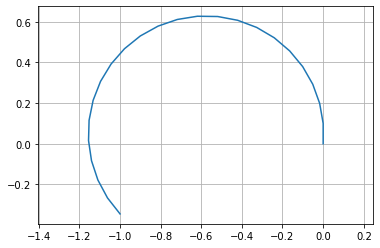

In [ ]:
# plot robot trajectory
plt.figure()
plt.grid()
plt.axis("equal")
plt.plot(robot_trajectory[:,0],robot_trajectory[:,1]) #plot xpos vs ypos
#plt.plot( )
plt.show()
#plt.plot( )

#show first and last robot positions with + markers
# example: plt.plot(0, 0, 'r+', ms=10)


### Shape the turn
Let us try something cooler than before (though a bit tricky in open loop). Instead of boring circular arcs, change the steering angle so that the robot orientation changes as shown in the equation below

$\theta = (\theta_i - \theta_f) * (1 - 3x^2 + 2\theta^3) + \theta_f  \thinspace \vee x \in [0,1]$

First let us plot this

In [ ]:
def poly_turn(theta_i, theta_f, n=10):
    x = np.linspace(0, 1, num=n)
    return (theta_i-theta_f) * (1 - 3 * x * x + 2 * (x**3)) + theta_f

How does a right turn look? 

In [ ]:
theta_dot = np.diff(poly_turn(np.pi/2, 0))
print(theta_dot)

[-0.05386819 -0.14436674 -0.20900856 -0.24779366 -0.26072202 -0.24779366
 -0.20900856 -0.14436674 -0.05386819]


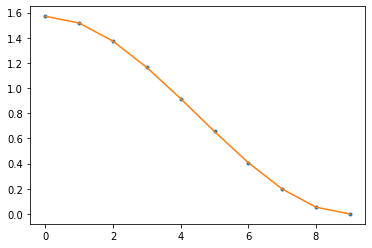

In [ ]:
plt.figure()
plt.plot(poly_turn(np.pi/2, 0),'.')
plt.plot(poly_turn(np.pi/2, 0))

Now plot a left turn (North to East)

In [ ]:
# plt.figure()
# plt.plot(poly_turn(),'.')
# plt.plot(poly_turn())

TypeError: ignored

<Figure size 432x288 with 0 Axes>

How does $\theta$ change when we had constant $\delta$? Plot it

In [ ]:
theta0 = np.pi/2
delta = 1
v = 1
L = 0.9
final = []
t = np.linspace(0.0, 10.0, 100)
theta = theta0
final.append(theta)
for i in range(len(t)-1):
  # print(t)
  theta = theta0 + (v/L)*np.tan(1)*i
  final.append(theta)

final = np.array(final)
# print(final)
  

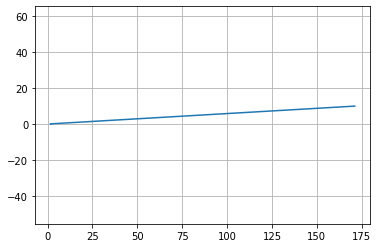

In [ ]:
# plot robot trajectory
plt.figure()
plt.grid()
# plt.figure()
plt.axis("equal")
plt.plot(final,t) #plot xpos vs ypos
#plt.plot( )
plt.show()

We know the rate of change of $\theta$ is proportional to $\delta$. Can you work out the sequence of $\delta$ to change $\theta$ as in the cubic polynomial shown above?

In [ ]:
vc = 1
L = 1
delta = np.arctan(theta_dot*L/vc)
print(delta)